# Visualizar la decisión del clasificador

En este notebook, usaremos Mapas de Activación de Clases (CAM) (https://arxiv.org/abs/1512.04150).  
Un método para visualizar las regiones de la imagen que son más importantes para la decisión del clasificador.

In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import os

Se usa el dataset anterior

In [2]:
def load_file(path):
    return np.load(path).astype(np.float32)


In [3]:
# Obtener la ruta del conjunto de datos de validación desde la variable de entorno
val_dataset_path = 'data/Processed/val'

# Definir las transformaciones para los datos de validación
val_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convierte la imagen a tensor
    transforms.Normalize(0.49, 0.248),  # Normaliza los datos con media y desviación estándar específicas
])

# Crear el conjunto de datos de validación usando la ruta obtenida
val_dataset = datasets.DatasetFolder(
    val_dataset_path,  # Ruta al directorio del conjunto de datos de validación
    loader=load_file,  # Función para cargar los archivos
    extensions="npy",  # Tipo de extensión de los archivos
    transform=val_transforms  # Aplicar las transformaciones definidas
)

La idea clave de CAM es multiplicar la salida de la última capa convolucional (BasicBlock 1 de la capa 4), $A_k$ (que consiste en k canales), con los parámetros $w$ de la capa totalmente conectada subsiguiente para calcular un mapa de activación $M$:
$$ M = \sum_k w_kA_k $$

Para hacerlo, necesitamos acceder a esta salida específica de la resnet18 entrenada.  

La arquitectura de ResNet: 


In [4]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Podemos convertir la red en un generador usando la función **children()**.  
Esto significa que podemos utilizar la función `list` para convertirla en una lista.  
La parte convolucional de la red comprende todas las capas hasta la capa `AdaptiveAvgPool2d`.

In [5]:
list(temp_model.children())[:-2]  # Obtener todas las capas hasta avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

Usando **Sequential** de PyTorch, convertimos la lista de capas de nuevo a un modelo secuencial (*Sequential Model*).

In [6]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Añadimos una salida adicional a la función `forward` de nuestro modelo de neumonía para devolver los mapas de características de la última capa convolucional ($A$).

Extraemos el mapa de características en el paso hacia adelante (*forward pass*), seguido de un *global average pooling* y aplanamiento.  
Finalmente, utilizamos la capa totalmente conectada para calcular la predicción final de la clase.

In [7]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # Crear el modelo base usando ResNet18 de torchvision
        self.model = torchvision.models.resnet18()
        
        # Cambiar la capa conv1 de 3 canales de entrada a 1, ya que las imágenes de rayos X son en escala de grises
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Cambiar la última capa totalmente conectada (llamada 'fc' en ResNet18) para que tenga solo una salida (clasificación binaria)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extraer las capas de características (feature map) de la red excluyendo las últimas dos capas
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    

    def forward(self, data):
        # Calcular el mapa de características usando las capas extraídas
        feature_map = self.feature_map(data)
        
        # Aplicar 'Adaptive Average Pooling' como en el modelo original
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)  # Imprimir la forma del tensor después del 'average pooling' para depuración
        
        # Aplanar la salida en un vector de 512 elementos
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)  # Imprimir la forma del tensor aplanado para depuración
        
        # Calcular la predicción utilizando la capa totalmente conectada (fc) del modelo
        pred = self.model.fc(avg_pool_output_flattened)
        
        # Retornar la predicción y el mapa de características
        return pred, feature_map


In [8]:
def cam(model, img):
    # Desactivar el cálculo de gradientes, ya que solo estamos evaluando
    with torch.no_grad():
        # Realizar una pasada hacia adelante en el modelo para obtener la predicción y los mapas de características
        pred, features = model(img.unsqueeze(0))  # Añadir una dimensión extra para simular un lote de tamaño 1

    # Reestructurar las características (features) a un tensor de tamaño (512, 49)
    features = features.reshape((512, 49))  # 512 canales y 49 (7x7) posiciones espaciales

    # Obtener los parámetros (pesos) de la capa totalmente conectada (fc) del modelo
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()  # Desactivar el seguimiento de gradientes para los pesos

    # Calcular el Mapa de Activación de Clase (CAM) usando el producto punto entre los pesos y las características
    cam = torch.matmul(weight, features)

    # Reestructurar el CAM a un tamaño de 7x7 para visualizarlo como una imagen
    cam_img = cam.reshape(7, 7).cpu()

    # Retornar el mapa de activación (cam_img) y la predicción (aplicando la función sigmoide para obtener un valor entre 0 y 1)
    return cam_img, torch.sigmoid(pred)

In [9]:
# Usar 'strict=False' para evitar que PyTorch cargue los pesos para self.feature_map
model = PneumoniaModel.load_from_checkpoint(
    #"/weights/weights_3.ckpt",
    "checkpoints/best-checkpoint.ckpt",
    strict=False
)

# Configurar el modelo en modo de evaluación (desactiva dropout, batch normalization, etc.)
model.eval();

/opt/anaconda3/envs/doctor/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight', 

## CAM

In [10]:
## CAM
# Ahora podemos definir la función CAM usando la fórmula mencionada anteriormente.
def cam(model, img):
    """
    Calcula el mapa de activación de clase (CAM) según el algoritmo CAM.
    """
    with torch.no_grad():  # Desactiva el cálculo de gradientes para optimizar la evaluación
        pred, features = model(img.unsqueeze(0))  # Añadir una dimensión extra para simular un lote
    b, c, h, w = features.shape  # Obtener las dimensiones del tensor de características (batch, canales, alto, ancho)

    # Reestructurar el tensor de características de 512x7x7 a 512x49 para simplificar la multiplicación
    features = features.reshape((c, h * w))
    
    # Obtener solo los pesos, no el sesgo (bias), de la capa totalmente conectada (fc)
    weight_params = list(model.model.fc.parameters())[0] 
    
    # Eliminar la información del gradiente de los pesos para permitir la conversión a numpy
    weight = weight_params[0].detach()
    print(weight.shape)

    # Calcular la multiplicación entre los pesos y las características usando la fórmula anterior.
    # Se utiliza matmul porque multiplica directamente cada filtro con los pesos y luego calcula la suma.
    # Esto produce un vector de 49 elementos (7x7)
    cam = torch.matmul(weight, features)
    print(features.shape)
    
    ### El siguiente bucle realiza las mismas operaciones de una forma menos optimizada
    # cam = torch.zeros((7 * 7))
    # for i in range(len(cam)):
    #     cam[i] = torch.sum(weight * features[:, i])
    ##################################################################
    
    # Normalizar y estandarizar el mapa de activación de clase (No siempre es necesario, por eso no se mostró en la lección)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)

    # Reestructurar el mapa de activación de clase a 7x7 y mover el tensor de vuelta a la CPU
    cam_img = cam_img.reshape(h, w).cpu()

    return cam_img, torch.sigmoid(pred)

def visualize(img, heatmap, pred):
    """
    Función para visualizar los mapas de activación de clase.
    """
    img = img[0]
    
    # Redimensionar el mapa de activación de 7x7 al tamaño original de la imagen (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]
    
    # Crear una figura con dos subgráficos
    fig, axis = plt.subplots(1, 2)
    
    # Mostrar la imagen original en el primer subgráfico
    axis[0].imshow(img, cmap="bone")
    
    # Superponer la imagen original con el mapa de activación ampliado en el segundo subgráfico
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")  # Superponer el mapa de activación con transparencia
    plt.title(f"Neumonía: {(pred > 0.5).item()}")


In [11]:
def visualize(img, cam, pred, label):
    # Extraer la primera imagen del lote
    img = img[0]
    
    # Redimensionar el mapa de activación (CAM) a 224x224 para que coincida con el tamaño de la imagen original
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]
    
    # Crear una figura con dos subgráficos
    fig, axis = plt.subplots(1, 2)
    
    # Mostrar la imagen original en el primer subgráfico
    axis[0].imshow(img, cmap="bone")
    
    # Mostrar la imagen original y superponer el mapa de activación en el segundo subgráfico
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")  # Superponer el CAM con una transparencia del 50% y usando el mapa de colores "jet"
    
    # Establecer el título con la predicción
    plt.title(f"{pred} - label {label}")

## Demostracion

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


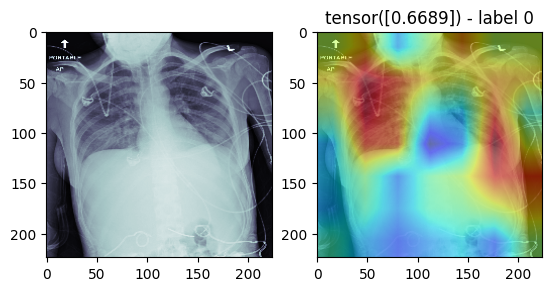

In [12]:
img = val_dataset[547][0]  # Seleccionar una imagen del conjunto de validación (en este caso, la sexta desde el final)
label = val_dataset[547][1]  # Seleccionar una imagen del conjunto de validación (en este caso, la sexta desde el final)
model = model.to('cpu') # mover el modelo al mismo dispositivo que los datos
activation_map, pred = cam(model, img)  # Calcular el mapa de activación de clase (CAM) y la predicción para la imagen seleccionada
visualize(img, activation_map, pred, label)  #  CAM

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


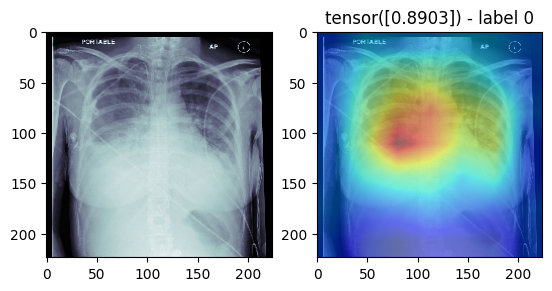

In [13]:
img = val_dataset[1318][0]  # Seleccionar una imagen del conjunto de validación (en este caso, la sexta desde el final)
label = val_dataset[1318][1]  # Seleccionar una imagen del conjunto de validación (en este caso, la sexta desde el final)
model = model.to('cpu') # mover el modelo al mismo dispositivo que los datos
activation_map, pred = cam(model, img)  # Calcular el mapa de activación de clase (CAM) y la predicción para la imagen seleccionada
visualize(img, activation_map, pred, label)  #  CAM

El mapa de calor se enfoca en el área que muestra signos de neumonía, ¿no es genial? ¡Increíble, lo has logrado!  
Puedes probar este método para todas las redes neuronales con una restricción: el algoritmo clásico de CAM requiere una arquitectura específica de red:  
Última convolución $\rightarrow$ *Global Average Pool* $\rightarrow$ 1 capa completamente conectada (*FC Layer*).

Para otras arquitecturas de red, necesitas adaptar la arquitectura, seguida de un nuevo entrenamiento, o usar métodos diferentes como GradCAM o ScoreCAM (https://arxiv.org/abs/1610.02391), (https://arxiv.org/abs/1910.01279).